# Predicting the sale price of bulldozers using Machine Learning


**Imports**

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Model & Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

**Importing Data and Parsing Time Series Data**

In [2]:
# Importing data
df = pd.read_csv('data/TrainAndValid.csv', 
                 low_memory=False,
                 parse_dates=['saledate'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

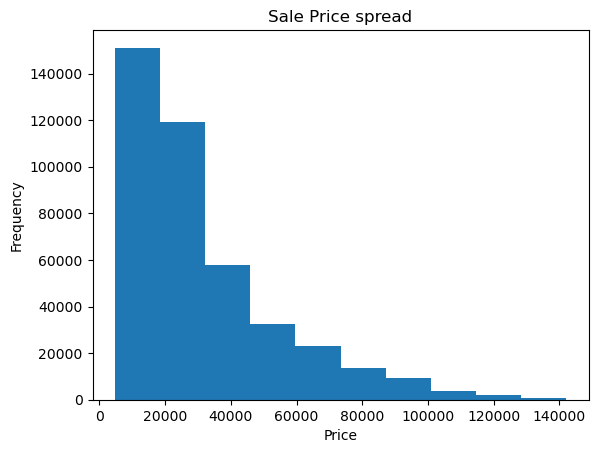

In [5]:
df.SalePrice.plot.hist()
plt.title('Sale Price spread')
plt.xlabel('Price')
plt.show();

Now I will plot sample of Sale Prices throughout the years ("saledate" column) to check if parsing went well.

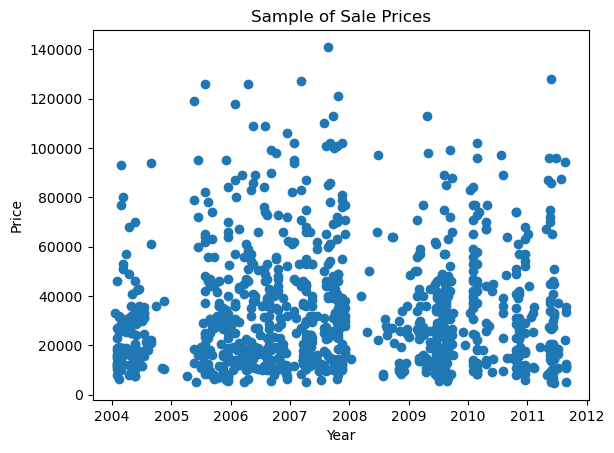

In [6]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])
ax.set_title('Sample of Sale Prices')
ax.set_ylabel('Price')
ax.set_xlabel('Year');

#### Imputing and disregarding missing data

In [7]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [8]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

In [9]:
# As you can see the sale dates aren't in ascending order

df.sort_values(by=['saledate'], inplace=True, ascending=True)

After sorting data I made copy, so I still have my original data

In [10]:
# Making a copy
dft = df.copy()

**Adding datetime parameters for `saledate` column**

In [11]:
dft['saleYear'] = dft.saledate.dt.year
dft['saleMonth'] = dft.saledate.dt.month
dft['saleDay'] = dft.saledate.dt.day
dft['saleDayOfWeek'] = dft.saledate.dt.dayofweek
dft['saleDayOfYear'] = dft.saledate.dt.dayofyear

In [12]:
dft.drop('saledate', axis=1, inplace=True)

**Converting strings into categories**

Thanks to that each string is now category with its own code.

In [13]:
for label, content in dft.items():
    if pd.api.types.is_object_dtype(content):
        dft[label] = content.astype("category").cat.as_ordered()

In [14]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

**Filling missing values**

In [15]:
# Checking percentage of missing values
dft.isna().sum()/len(dft)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [16]:
# Checking which numeric rows have NaN values
for label, content in dft.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [17]:
# Filling previously found columns and adding "missing" column
for label, content in dft.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            dft[label+'_is_missing'] = pd.isnull(content)
            dft[label] = content.fillna(content.median())

In [18]:
# Checking which categorical rows have NaN values:
for label, content in dft.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [19]:
# Filling previously found columns and adding "missing" column
for label, content in dft.items():
    if not pd.api.types.is_numeric_dtype(content):
        dft[label+'_is_missing'] = pd.isnull(content)
        dft[label] = pd.Categorical(content).codes + 1

I changed the codes of the categorical values, because default code for NaN value is -1. By adding 1 to every code, NaN values now have code 0, which is typical value for baseline or default value in machine learning algorithms. 

In [20]:
dft.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

#### Spliting data and evaluation function

In [21]:
# Splitting data into train/validation sets
df_val = dft[dft.saleYear == 2012]
df_train = dft[dft.saleYear != 2012]

# Training set
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
# Validation set
X_val, y_val = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

In [22]:
# Evaluation function - competition
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    :param y_test: test values
    :param y_preds: predicted values
    :return: RMSLE of y_test and y_preds
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Evaluation function - personal use
def show_scores(model):
    """
    Calculates MAE, RMSLE and R^2 for both train and validation sets.
    :param model: Created sklearn model.
    :return: Dictionary of calculated scores.
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_val, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_val, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_val, val_preds)}
    return scores

#### Model tuning

In [23]:
# max_samples values set to: 10 000
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [24]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

In [25]:
%%time
# Parameters distribution
rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt'],
           'max_samples': [10000]}

# RandomizedSearchCV model
rs_model = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions=rf_grid,
    n_iter=5,
    cv=5,
    verbose=True
)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 11.4 s
Wall time: 31.3 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [26]:
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 4,
 'min_samples_leaf': 17,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [27]:
show_scores(rs_model)

{'Training MAE': 9321.293006502008,
 'Valid MAE': 10916.810241995854,
 'Training RMSLE': 0.40720127974331577,
 'Valid RMSLE': 0.4333764102450496,
 'Training R^2': 0.6564366123171694,
 'Valid R^2': 0.6605672062025991}

#### Training model with best hyperparameters

In [28]:
%%time
new_model = RandomForestRegressor(
    n_estimators=40,
    min_samples_leaf=1,
    min_samples_split=14,
    max_features=0.5,
    n_jobs=-1,
    max_samples=None,
    random_state=42
)

new_model.fit(X_train, y_train)

CPU times: total: 5min 16s
Wall time: 28.4 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [29]:
show_scores(new_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

#### Predictions on test data

**Preprocessing test data**

In [30]:
df_test = pd.read_csv('data/Test.csv',
                      low_memory=False,
                      parse_dates=['saledate'])

In [31]:
# Preprocessing test data
def preprocess_data(df):
    """
    Performs transformations (filling NaN values and converting to numeric) on given DataFrame.
    :param df: DataFrame to be transformed
    :return: Preprocessed DataFrame
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+'_is_missing'] = pd.isnull(content)
                df[label] = content.fillna(content.median())
        else:
            df[label+'_is_missing'] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1
    return df

In [32]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [33]:
# Checking if number of columns is equal
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [34]:
# Checking index of missing column and inserting False values
index = X_train.columns.get_loc('auctioneerID_is_missing')

df_test.insert(index, 'auctioneerID_is_missing', False)

**Predictions**

In [35]:
# Predictions
test_preds = new_model.predict(df_test)

In [36]:
# Predictions into Kaggle format
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds

In [37]:
# Exporting into csv
df_preds.to_csv('data/test_predictions.csv', index=False)

#### Feature Importance

After making predictions and submitting them into Kaggle I decided to figure out which different attributes of the data were most important when it comes to predicting **target variable**.

In [38]:
def plot_importance(columns, importances, n=20):
    """
    Function to plot feature importance bar graph.
    :param columns: List of column names
    :param importances: feature_importances_ parameter of the model
    :param n: Number of features to be plotted (default: 20)
    :return: Bar plot of feature importance.
    """
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

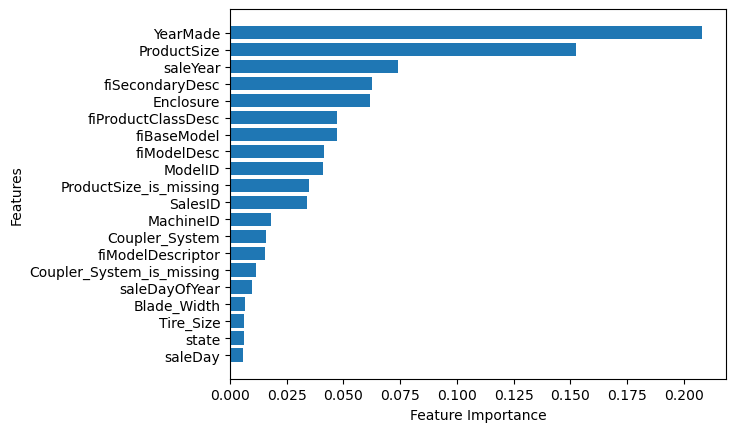

In [39]:
plot_importance(X_train.columns, new_model.feature_importances_)